# LangGraph：大模型时代的工作流编排框架

在大模型应用开发中，我们经常需要将多个任务连接起来，组成一个完整的工作流。例如，将检索与大模型生成结合的RAG系统，或者将多个大模型与各种工具组合的智能体系统。LangGraph就是一个为智能体和工作流设计的底层编排框架，它是LangChain生态的一部分。
今天，我们将一起探索LangGraph的核心概念和使用方法，带你快速上手这个强大的工作流框架。

## 1. 安装LangGraph

首先需要安装langgraph：

In [20]:
# %pip install langgraph

## 2. LangGraph的关键概念

LangGraph基于状态机的思想来设计工作流，主要有以下几个核心概念：

StateGraph：将工作流定义成一个状态机

Node：工作流中的节点，代表一个具体的处理步骤

Edge：边，定义节点之间的跳转关系

State：状态，随着工作流的进行可以被更新

接下来我们通过实例来理解这些概念。

## 3. 一个最基础的聊天机器人

In [21]:
from typing import Annotated
from typing_extensions import TypedDict
from langgraph.graph import StateGraph, START, END
from langgraph.graph.message import add_messages

# 定义状态类，描述工作流中状态的结构
class State(TypedDict):
    # messages字段是一个列表，更新方式是add_messages
    messages: Annotated[list, add_messages]

# 创建状态图
graph_builder = StateGraph(State)

上面的代码中，我们定义了一个简单的State类，它包含一个messages字段，这个字段会随着聊天的进行不断更新。add_messages是一个特殊的更新方法，它会将新的消息列表追加到原来的列表后面。

接下来，我们定义聊天机器人的处理逻辑：

In [22]:
from langchain.chat_models import init_chat_model
from langchain.schema import AIMessage, HumanMessage

# 初始化语言模型
llm = init_chat_model("gpt-4o", model_provider="openai")

# 定义聊天机器人节点的处理函数
def chatbot(state: State):
    # 调用大模型，并返回响应消息
    return {"messages": [llm.invoke(state["messages"])]}

# 添加节点和边
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "chatbot")
graph_builder.add_edge("chatbot", END)

# 编译图
graph = graph_builder.compile()

在这个例子中，我们创建了一个名为"chatbot"的节点，它的处理逻辑是调用大模型回答用户问题。

然后我们添加了两条边：一条从START到chatbot，一条从chatbot到END。这就定义了一个简单的工作流：用户输入 -> 大模型回答 -> 结束。

我们可以可视化这个工作流：

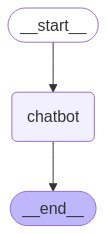

In [23]:
from IPython.display import Image, display

try:
    display(Image(data=graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

接下来，我们创建一个函数来运行这个工作流：

In [24]:
def stream_graph_updates(user_input: str):
    # 向graph传入用户消息，触发状态更新
    for event in graph.stream({"messages": [{"role": "user", "content": user_input}]}):
        for value in event.values():
            # 检查返回值中是否包含AI消息
            if "messages" in value and isinstance(value["messages"][-1], AIMessage):
                print("Assistant:", value["messages"][-1].content)

def run():
    # 执行工作流
    while True:
        user_input = input("User: ")
        if user_input.strip() == "":
            break
        stream_graph_updates(user_input)

现在可以测试这个简单的聊天机器人了：

In [25]:
run()

Assistant: 你好！有什么我可以帮助你的吗？


当我们输入"你好"时，大模型会回复一个问候语。这就是一个最简单的LangGraph工作流。

## 4. 构建RAG系统

接下来，让我们实现一个更复杂的例子：基于检索增强生成(RAG)的问答系统。

首先，我们需要准备文档数据和向量检索组件：

In [26]:
from langchain_openai import OpenAIEmbeddings
from langchain_text_splitters import RecursiveCharacterTextSplitter
from langchain_community.vectorstores import FAISS
from langchain_community.document_loaders import PyMuPDFLoader

# 加载文档
loader = PyMuPDFLoader("./data/rag_data/llama2.pdf")
pages = loader.load_and_split()

# 文档切分
text_splitter = RecursiveCharacterTextSplitter(
    chunk_size=300,
    chunk_overlap=100,
    length_function=len,
    add_start_index=True,
)

texts = text_splitter.create_documents(
    [page.page_content for page in pages[:4]]
)

# 创建向量数据库
embeddings = OpenAIEmbeddings(model="text-embedding-ada-002")
db = FAISS.from_documents(texts, embeddings)

# 创建检索器
retriever = db.as_retriever(search_kwargs={"k": 3})

然后，我们定义检索节点和处理逻辑：

In [27]:
from langchain.prompts import ChatPromptTemplate, HumanMessagePromptTemplate

# Prompt模板
template = """请根据对话历史和下面提供的信息回答上面用户提出的问题:
{input}
"""
prompt = ChatPromptTemplate.from_messages(
    [
        HumanMessagePromptTemplate.from_template(template),
    ]
)

# 检索节点的处理函数
def retrieval(state: State):
    user_query = ""
    if len(state["messages"]) >= 1:
        # 获取最后一轮用户输入
        user_query = state["messages"][-1]
    else:
        return {"messages": []}
    # 执行检索
    docs = retriever.invoke(str(user_query))
    # 填充prompt模板
    messages = prompt.invoke({"input": "\n".join([doc.page_content for doc in docs])}).messages
    return {"messages": messages}

现在，我们可以构建包含检索和生成两个节点的工作流：

In [28]:
# 创建新的工作流
graph_builder = StateGraph(State)
graph_builder.add_node("retrieval", retrieval)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_edge(START, "retrieval")
graph_builder.add_edge("retrieval", "chatbot")
graph_builder.add_edge("chatbot", END)

# 编译图
graph = graph_builder.compile()

这个工作流的流程是：用户输入 -> 检索相关文档 -> 大模型回答 -> 结束。可以使用前面定义的run函数测试这个RAG系统。

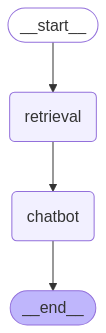

In [31]:
from IPython.display import Image, display

try:
    display(Image(data=graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [12]:
run()

Assistant: Llama 2有不同的变体模型，其中包括具有7B、13B和70B参数的版本。


## 5. 添加条件分支：未找到答案转人工

接下来，我们进一步完善这个系统，添加一个判断逻辑：如果检索到的信息不足以回答用户问题，则将问题转给人工处理。

In [32]:
from typing import Literal
from langgraph.types import interrupt, Command

# 添加判断节点
def verify(state: State) -> Literal["chatbot", "ask_human"]:
    message = HumanMessage("请根据对话历史和上面提供的信息判断，已知的信息是否能够回答用户的问题。直接输出你的判断'Y'或'N'")
    ret = llm.invoke(state["messages"] + [message])
    if 'Y' in ret.content:
        return "chatbot"
    else:
        return "ask_human"

# 添加转人工节点
def ask_human(state: State):
    user_query = state["messages"][-2].content if len(state["messages"]) >= 2 else "未找到问题"
    human_response = interrupt(
       {
          "question": user_query
       }
    )
    # 返回人工回复
    return {
        "messages": [AIMessage(human_response)]
    }

上面的代码中，verify函数用于判断检索到的信息是否足够回答问题。ask_human函数则用于中断工作流，等待人工输入回复。

接下来，我们需要创建一个内存存储器来保存工作流的状态：

In [33]:
from langgraph.checkpoint.memory import MemorySaver

# 创建内存存储器
memory = MemorySaver()

# 创建新的工作流
graph_builder = StateGraph(State)
graph_builder.add_node("retrieval", retrieval)
graph_builder.add_node("chatbot", chatbot)
graph_builder.add_node("ask_human", ask_human)

# 添加边和条件边
graph_builder.add_edge(START, "retrieval")
graph_builder.add_conditional_edges("retrieval", verify)  # 条件分支
graph_builder.add_edge("ask_human", END)
graph_builder.add_edge("chatbot", END)

# 编译图，指定checkpointer
graph = graph_builder.compile(checkpointer=memory)

最后，我们需要修改运行函数以支持人工干预：

In [34]:
# 配置线程ID
thread_config = {"configurable": {"thread_id": "my_thread_id"}}

def stream_graph_updates(user_input: str):
    # 向graph传入用户消息，触发状态更新
    for event in graph.stream(
        {"messages": [{"role": "user", "content": user_input}]},
        thread_config
    ):
        for value in event.values():
            if isinstance(value, tuple):
                # 返回需要人工回答的问题
                return value[0].value["question"]
            elif "messages" in value and isinstance(value["messages"][-1], AIMessage):
                # 打印AI回复
                print("Assistant:", value["messages"][-1].content)
                return None
    return None

def resume_graph_updates(human_input: str):
    # 恢复工作流，提供人工回复
    for event in graph.stream(
        Command(resume=human_input), thread_config, stream_mode="updates"
    ):
        for value in event.values():
            if "messages" in value and isinstance(value["messages"][-1], AIMessage):
                print("Assistant:", value["messages"][-1].content)

def run():
    # 执行工作流
    while True:
        user_input = input("User: ")
        if user_input.strip() == "":
            break
        question = stream_graph_updates(user_input)
        if question:
            # 需要人工干预
            human_answer = input(f"Ask Human: {question}\nHuman: ")
            resume_graph_updates(human_answer)

现在，我们的系统可以智能地判断是自动回答还是转人工回答问题了。

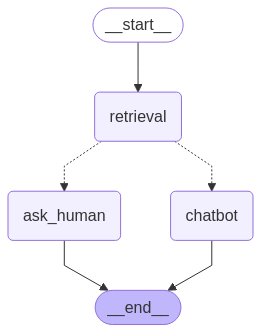

In [35]:
from IPython.display import Image, display

try:
    display(Image(data=graph.get_graph().draw_mermaid_png()))
except Exception as e:
    print(e)

In [18]:
run()

Assistant: Llama 2 模型有不同的变体，包括 7B、13B 和 70B 参数。
Assistant: 今天是2025年5月11号


LangGraph还支持许多高级功能：

工具调用：允许节点调用外部工具或API来执行特定任务
并行处理：支持多个节点并行执行，提高效率
状态持久化：可以将工作流状态持久化存储，支持长时间运行的任务
对话历史管理：提供对话历史的管理功能，方便上下文理解
历史动作回放：支持回放历史动作，方便调试与测试
子图管理：支持将复杂工作流拆分为多个子图
多智能体协作：支持多个智能体之间的协作

总结

LangGraph是一个功能强大的工作流编排框架，它为大模型应用开发提供了灵活的工作流管理能力。通过本文的介绍，我们学习了LangGraph的基本概念和使用方法，并实现了从简单聊天机器人到带有条件分支的RAG系统的进阶示例。

LangGraph的优势在于它的灵活性和可扩展性，可以轻松地构建复杂的智能应用工作流。如果你正在开发基于大模型的应用，LangGraph绝对是一个值得学习和使用的工具。

更多关于LangGraph的内容，可以参考官方文档：https://langchain-ai.github.io/langgraph/how-tos